# HW5B Problem 1A

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

In [2]:
def generate_uniform_samples(lower_bound, upper_bound, num_samples):
    random_values = np.random.uniform(0, 1, num_samples)
    result = lower_bound + random_values * (upper_bound - lower_bound)
    return result

In [6]:
def sample_gaussian_by_rejection(mean, std_dev, target_count):
    # Define the range of the uniform distribution: mean ± 3*std_dev
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    
    # Uniform distribution height, which covers the peak of the Gaussian
    uniform_height = 1 / (upper_bound - lower_bound)
    gaussian_peak = norm.pdf(mean, mean, std_dev)  # Peak of the Gaussian at mean
    scaling_factor = gaussian_peak / uniform_height  # Maximum value of f(x)/g(x)
    
    result = []
    while len(result) < target_count:
        candidate = np.random.uniform(lower_bound, upper_bound)
        # Calculate acceptance probability
        acceptance_prob = norm.pdf(candidate, mean, std_dev) / (scaling_factor * uniform_height)
        # Draw a uniform random number to decide acceptance
        random_check = np.random.uniform(0, 1)
        if random_check < acceptance_prob:
            result.append(candidate)
    
    return result

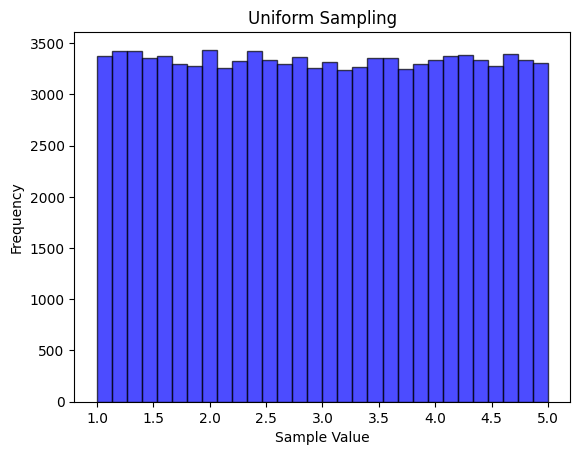

In [4]:
generated_data = generate_uniform_samples(1, 5, 100000)
plt.hist(generated_data, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Uniform Sampling')
plt.xlabel('Sample Value')
plt.ylabel('Frequency')
plt.show()

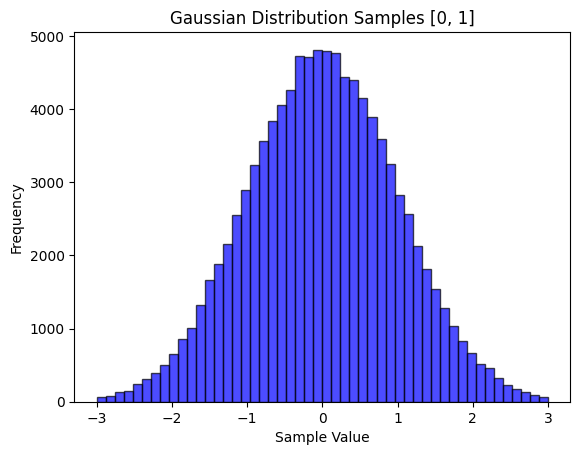

In [7]:
mean_value = 0
std_deviation = 1
sample_size = 100000
generated_points = sample_gaussian_by_rejection(mean_value, std_deviation, sample_size)
plt.hist(generated_points, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title(f'Gaussian Distribution Samples [{mean_value}, {std_deviation}]')
plt.xlabel('Sample Value')
plt.ylabel('Frequency')
plt.show()

# Problem 01B

In [8]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

def sample_bivariate_gaussian(mean_vector, covariance_matrix, domain_limits, target_count):
    distribution = multivariate_normal(mean=mean_vector, cov=covariance_matrix)
    
    x_lower, x_upper, y_lower, y_upper = domain_limits
    region_area = (x_upper - x_lower) * (y_upper - y_lower)
    max_density = distribution.pdf(mean_vector)
    scaling_constant = max_density * region_area
    
    result_points = []
    while len(result_points) < target_count:
        x_coord = np.random.uniform(x_lower, x_upper)
        y_coord = np.random.uniform(y_lower, y_upper)
        candidate_point = np.array([x_coord, y_coord])
        acceptance_prob = distribution.pdf(candidate_point) / (scaling_constant / region_area)
        random_threshold = np.random.uniform(0, 1)
        if random_threshold < acceptance_prob:
            result_points.append(candidate_point)
    return np.array(result_points)


mean_vector = np.array([0, 0])
covariance_matrix = np.array([[1, 0.5], [0.5, 2]])
domain_limits = [-10, 10, -10, 10]
target_count = 1000
result_points = sample_bivariate_gaussian(mean_vector, covariance_matrix, domain_limits, target_count)

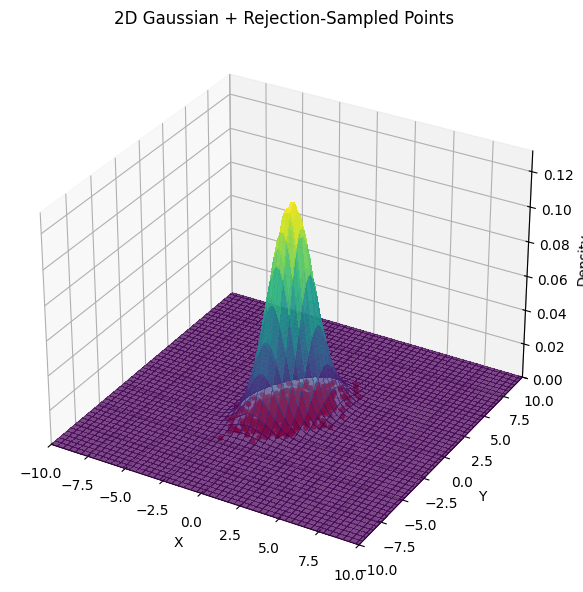

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# unpack your domain and distribution
x_min, x_max, y_min, y_max = domain_limits
# build a regular grid over the same rectangle
grid_size = 100
xs = np.linspace(x_min, x_max, grid_size)
ys = np.linspace(y_min, y_max, grid_size)
X, Y = np.meshgrid(xs, ys)
# stack and evaluate the PDF on that grid
distribution = multivariate_normal(mean=mean_vector, cov=covariance_matrix)
pos = np.dstack((X, Y))
Z = distribution.pdf(pos)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 1) plot the Gaussian surface
ax.plot_surface(
    X, Y, Z,
    cmap='viridis',
    alpha=0.7,
    linewidth=0,
    antialiased=False
)

# 2) scatter your samples at z=0 (the “floor”)
ax.scatter(
    result_points[:, 0],
    result_points[:, 1],
    np.zeros_like(result_points[:, 0]),
    c='r',
    s=10,
    alpha=0.6
)

# labels & limits
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Density')
ax.set_title('2D Gaussian + Rejection-Sampled Points')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(0, Z.max() * 1.1)

plt.tight_layout()
plt.show()


# Problem 01C

In [12]:
def stratified_probability_sampling(elements, selection_weights, sample_size, strata_count):
  
    sorted_indices = np.argsort(selection_weights)
    ordered_elements = elements[sorted_indices]
    ordered_weights = selection_weights[sorted_indices]
    plt.bar(range(len(ordered_weights)), ordered_weights, color='red')
    plt.title("Sorted Probability")
    plt.xlabel("Items")
    plt.ylabel("Probability")
    plt.show()
    
    strata = np.array_split(ordered_elements, strata_count)
    strata_weights = np.array_split(ordered_weights, strata_count)
    strata_weight_sums = [stratum.sum() for stratum in strata_weights]
    
    plt.bar(range(strata_count), strata_weight_sums, color='green')
    plt.title("Group Probability")
    plt.xlabel("Group Index")
    plt.ylabel("Cumulative Probability")
    plt.show()
    
    selected_strata = np.random.choice(strata_count, size=sample_size, p=strata_weight_sums/np.sum(strata_weight_sums))
    strata_sample_counts = np.bincount(selected_strata, minlength=strata_count)
    
    plt.bar(range(strata_count), strata_sample_counts, color='blue')
    plt.title("Number of samples in group")
    plt.xlabel("Group Number")
    plt.ylabel("Number of samples chosen")
    plt.show()
    
    result_samples = []
    for stratum_idx, sample_count in enumerate(strata_sample_counts):
        if sample_count > 0:
            current_stratum = strata[stratum_idx]
            actual_count = min(sample_count, len(current_stratum))
            selected_elements = np.random.choice(current_stratum, size=actual_count, replace=False)
            result_samples.extend(selected_elements)
            
    return result_samples

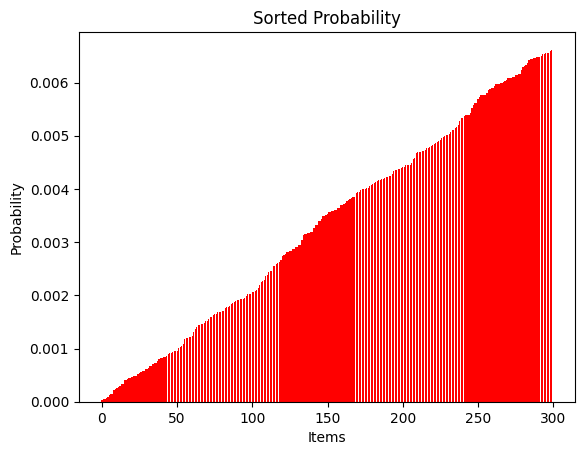

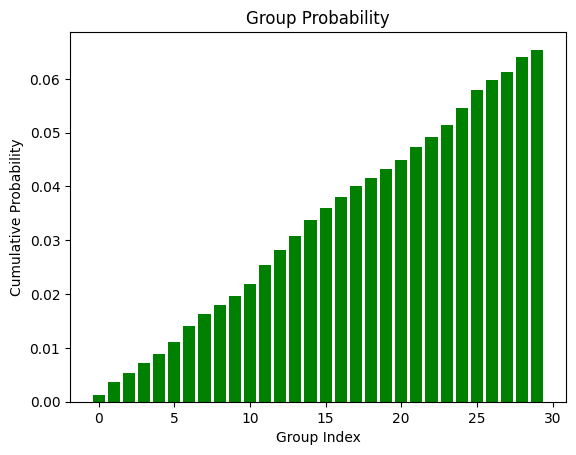

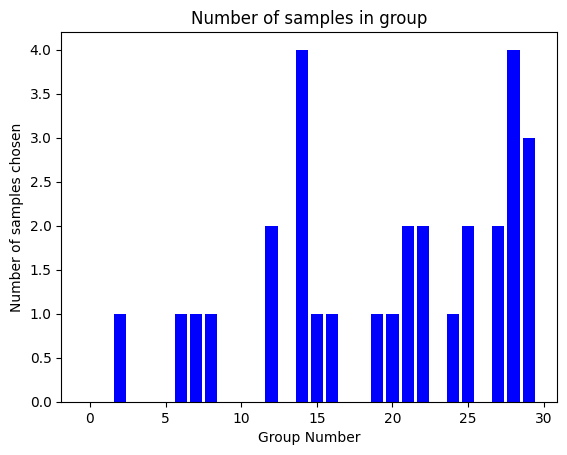

Sampled Items: [72, 282, 99, 145, 62, 281, 288, 20, 77, 26, 130, 44, 259, 141, 236, 278, 249, 209, 289, 210, 47, 30, 18, 171, 129, 57, 189, 269, 98, 102]


In [13]:
items= np.arange(300)
probabilities = np.random.rand(300)
probabilities/= probabilities.sum()  # normalization

num_groups = 30  # number of groups
k = num_groups

samples = stratified_probability_sampling(items, probabilities, k, num_groups)
print("Sampled Items:", samples)

# Problem 02

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

def sample_bivariate_gaussian_gibbs(mean_vector, covariance_matrix, iterations=1000):
    covariance_matrix = np.array(covariance_matrix) 
    current_x, current_y = 0, 0 
    result_points = np.zeros((iterations, 2))
    
    var_xx = covariance_matrix[0, 0]
    var_yy = covariance_matrix[1, 1]
    covar_xy = covariance_matrix[0, 1]
    
    for step in range(iterations):
        conditional_mean_y = mean_vector[1] + covar_xy * (current_x - mean_vector[0]) / var_xx
        conditional_std_y = np.sqrt(var_yy - covar_xy**2 / var_xx)
        current_y = np.random.normal(conditional_mean_y, conditional_std_y)
        
        conditional_mean_x = mean_vector[0] + covar_xy * (current_y - mean_vector[1]) / var_yy
        conditional_std_x = np.sqrt(var_xx - covar_xy**2 / var_yy)
        current_x = np.random.normal(conditional_mean_x, conditional_std_x)
        
        result_points[step, :] = [current_x, current_y]
    return result_points

In [15]:
mu = np.array([0, 0])
sigma = np.array([[1, 0.5], [0.5, 1]])

samples = sample_bivariate_gaussian_gibbs(mu, sigma, iterations=1000)

sample_mean = np.mean(samples, axis=0)
sample_cov = np.cov(samples.T)

print("Sample statistics:")
print(f"Mean: {sample_mean}")
print(f"Covariance:\n{sample_cov}")
print("\nTarget statistics:")
print(f"Mean: {mu}")
print(f"Covariance:\n{sigma}")

Sample statistics:
Mean: [-0.01716148 -0.03249288]
Covariance:
[[1.0567718  0.56679427]
 [0.56679427 1.03811447]]

Target statistics:
Mean: [0 0]
Covariance:
[[1.  0.5]
 [0.5 1. ]]


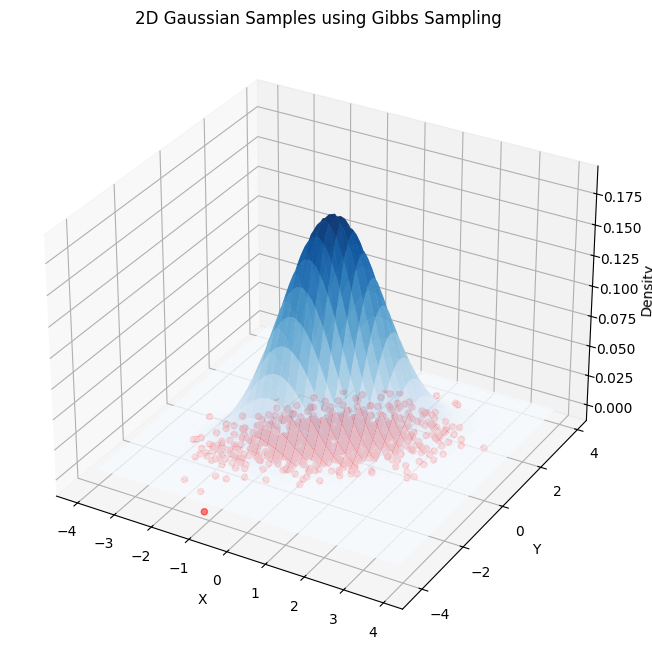

In [16]:
distribution = multivariate_normal(mean=mu, cov=sigma)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
grid_x, grid_y = np.mgrid[-4:4:.1, -4:4:.1]
coordinate_grid = np.empty(grid_x.shape + (2,))
coordinate_grid[:, :, 0] = grid_x
coordinate_grid[:, :, 1] = grid_y

density_values = distribution.pdf(coordinate_grid)
ax.plot_surface(grid_x, grid_y, density_values, cmap='Blues', alpha=0.8)
ax.scatter(samples[:, 0], samples[:, 1], np.zeros_like(samples[:, 0]), color='red', alpha=0.5)
ax.set_title("2D Gaussian Samples using Gibbs Sampling")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Density')
ax.grid(True)
plt.show()

# Problem 03

In [17]:
data_20ng = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),categories=["alt.atheism", "sci.med", "sci.electronics", "comp.graphics", "talk.politics.guns", "sci.crypt"])
documents_20ng = data_20ng.data
vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=10, max_features=500)
vectorized = vectorizer.fit_transform(documents_20ng)
vocab_20ng = vectorizer.get_feature_names_out()


docs = []
for doc_idx in range(vectorized.shape[0]):
    word_indices = vectorized[doc_idx].indices 
    docs.append(list(word_indices))

In [18]:
def lda_gibbs_sampler(docs, vocab, K, alpha, beta, iterations= 1000):
    D = len(docs)  
    W = len(vocab)
    DLMAX = max(len(doc) for doc in docs)

    A = np.zeros((D, K)) + alpha 
    B = np.zeros((K, W)) + beta 
    Z = np.zeros((D, DLMAX), dtype=int)
    
    for d in range(D):
        for i, word in enumerate(docs[d]):
            topic   = np.random.randint(K)
            Z[d, i] = topic
            A[d, topic] += 1
            B[topic, word] += 1

    for iteration in range(iterations):
        for d in range(D):
            for i, word in enumerate(docs[d]):
                current_topic = Z[d, i]
                # Decrement counts
                A[d, current_topic] -= 1
                B[current_topic, word] -= 1

                # Calculate topic distribution
                prob = (A[d, :] * (B[:, word] / B.sum(axis=1)))
                prob /= prob.sum()
                new_topic = np.random.choice(K, p=prob)

                # Update counts and assignment
                Z[d, i] = new_topic
                A[d, new_topic] += 1
                B[new_topic, word] += 1

    return Z, A, B

In [20]:
K = 6
alpha = np.ones(K)   * 5
beta  = np.ones(500) * 2

Z, A, B = lda_gibbs_sampler(docs, vocab_20ng, K, alpha, beta)

from wordcloud import WordCloud

def plot_topics(B, vocab):
    for k in range(B.shape[0]):
        freq = dict(zip(vocab, B[k, :]))
        wc = WordCloud().generate_from_frequencies(freq)
        plt.figure()
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {k+1}')
        plt.show()

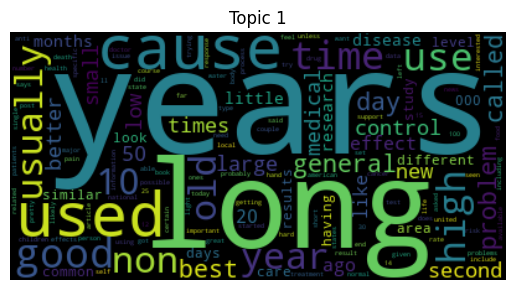

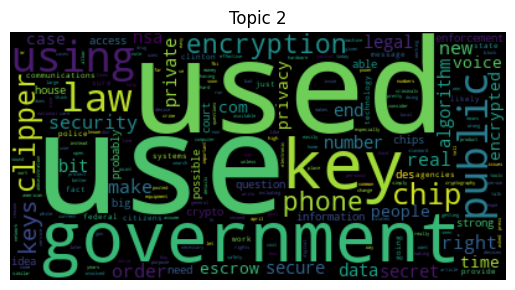

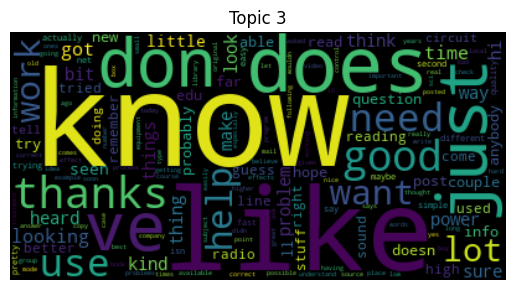

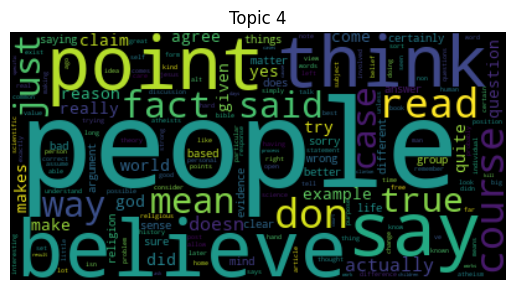

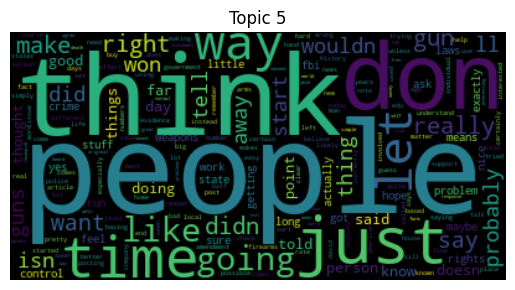

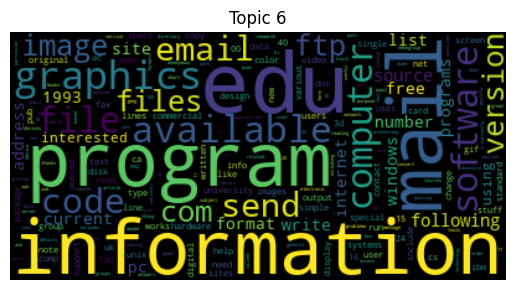

In [21]:
plot_topics(B, vocab_20ng)

In [22]:
with open('sonnetsPreprocessed.txt', 'r') as file:
    sonnets = file.read().splitlines()

vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=2, max_features=1000)
doc_word_matrix = vectorizer.fit_transform(sonnets)
vocab = vectorizer.get_feature_names_out()

docs = [list(doc.indices) for doc in doc_word_matrix]

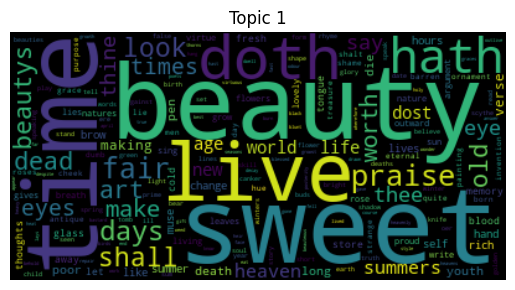

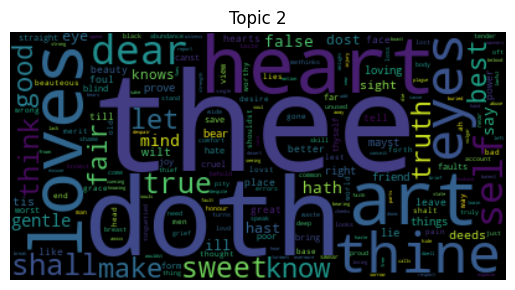

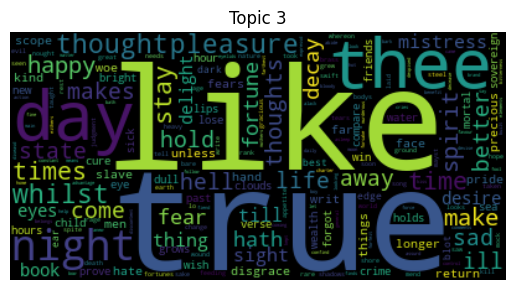

In [23]:
K = 3
alpha = np.ones(K) * 0.6
beta  = np.ones(len(vocab)) * 0.6
iterations = 500
Z, A, B = lda_gibbs_sampler(docs, vocab, K, alpha, beta, iterations)

# Display topics
plot_topics(B, vocab)